# Sound Feature Embedding of Canary Song

## Setup

In [3]:
pip install numpy scipy pyAudioAnalysis eyed3 pydub umap-learn hdbscan

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━━ 37.7/41.3 MB 190.6 MB/s eta 0:00:01
ERROR: Operation cancelled by user


In [ ]:
# Import Libraries
import numpy as np
import scipy
from scipy.io import wavfile
import numpy as np
import scipy
import pyAudioAnalysis as pyA
from pyAudioAnalysis import audioBasicIO
from pyAudioAnalysis import ShortTermFeatures
import matplotlib.pyplot as plt

In [4]:
# Mount Drive to access files on google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Test that you can access relevant files -- and choose file for analysis
from scipy.io import wavfile
demoFile = '/content/drive/MyDrive/Rose_Bird/Demo_Wav_files/USA5207_45107.23982155_6_30_6_39_42.wav'
samplerate, data = wavfile.read(demoFile)

## Defining Functions

In [6]:
# Obtain Slices
def get_matrix_slices(matrix, window_size, step_size):
    matrix_shape = matrix.shape
    num_slices = (matrix_shape[1] - window_size) // step_size + 1
    slices = np.zeros((matrix_shape[0], window_size, num_slices))
    start_times = np.zeros((num_slices))

    for i in range(num_slices):
        start = i * step_size
        end = start + window_size
        slices[:, :, i] = matrix[:, start:end]
        start_times[i] = start

    return slices,start_times

# Wav file to feature matrix
def wavToFeat(inputFile,windowMs,stepMs):
  samplerate, data = wavfile.read(inputFile)
  fakeTimeMax = len(data)/samplerate
  F, f_names = ShortTermFeatures.feature_extraction(data, samplerate, windowMs*samplerate/1000, stepMs*samplerate/1000)
  fakeOutTime = np.linspace(0,fakeTimeMax,num = F.shape[1])

  return F,f_names,fakeOutTime

# Wav file to spectrogram (w/ log thresholding)
def wavToSpec(inputFile,**kwargs):
  samplerate, data = wavfile.read(inputFile)
  FS = samplerate # input
  NFFT = 512
  noverlap = 450  # noverlap > NFFT/2

  # Create Spectrogram
  spectrum, freqs, t, im = plt.specgram(data, NFFT=NFFT, Fs=FS, noverlap=noverlap,cmap='jet')

  # Manual Params (can be changed)
  logThresh = 10
  afterThresh = 4

  # Take log then delete elements below another thresh after log
  filterSpec = np.log(spectrum + logThresh)
  filterSpec[np.where(filterSpec < afterThresh)] = 0

  return filterSpec, t, freqs

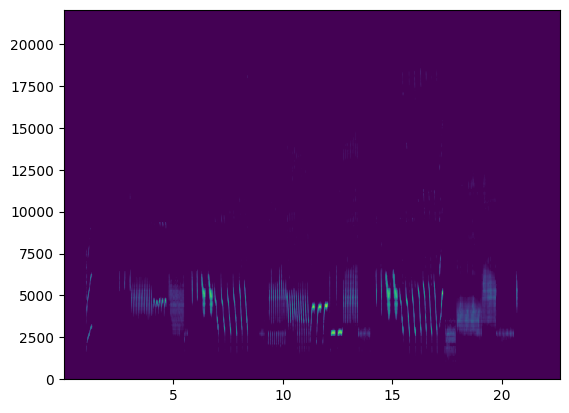

In [7]:
filtSpec, t, freqs = wavToSpec(demoFile)
plt.imshow(filtSpec,aspect = 'auto',origin = 'lower',extent = [t[0],t[-1],freqs[0],freqs[-1]])

## Analysis

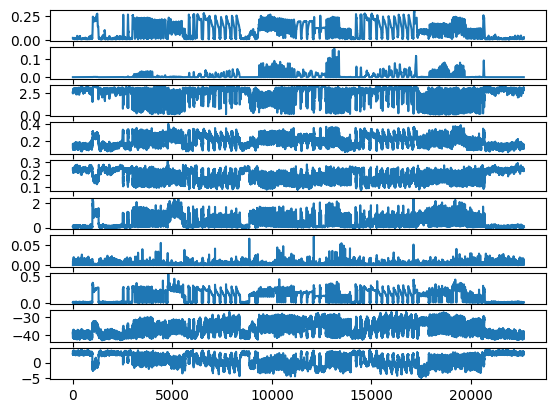

In [8]:
# Feat params
windowMs = 20
stepMs = 1

# UMAP slicing param in pixels/bins
window_size = 100
step_size = 1

# try zscore

# Obtain features and make slices
feats,names,fakeT = wavToFeat(demoFile,windowMs = windowMs, stepMs = stepMs)
slices, start_times = get_matrix_slices(feats,window_size, step_size)

# feats = scipy.stats.zscore(feats)


colorTime = fakeT[start_times.astype(int)]
# Turn each slice into a 1D vector
original_shape = slices.shape
flattened_matrix = slices.reshape(original_shape[0] * original_shape[1], original_shape[2]).T

# plot first 10 features
for i in range(10):
  plt.subplot(10,1,i + 1)
  plt.plot(feats[i,:])

In [9]:
# Load the umap library, and transform the data
import umap
fit = umap.UMAP()
spec_emb = fit.fit_transform(flattened_matrix)

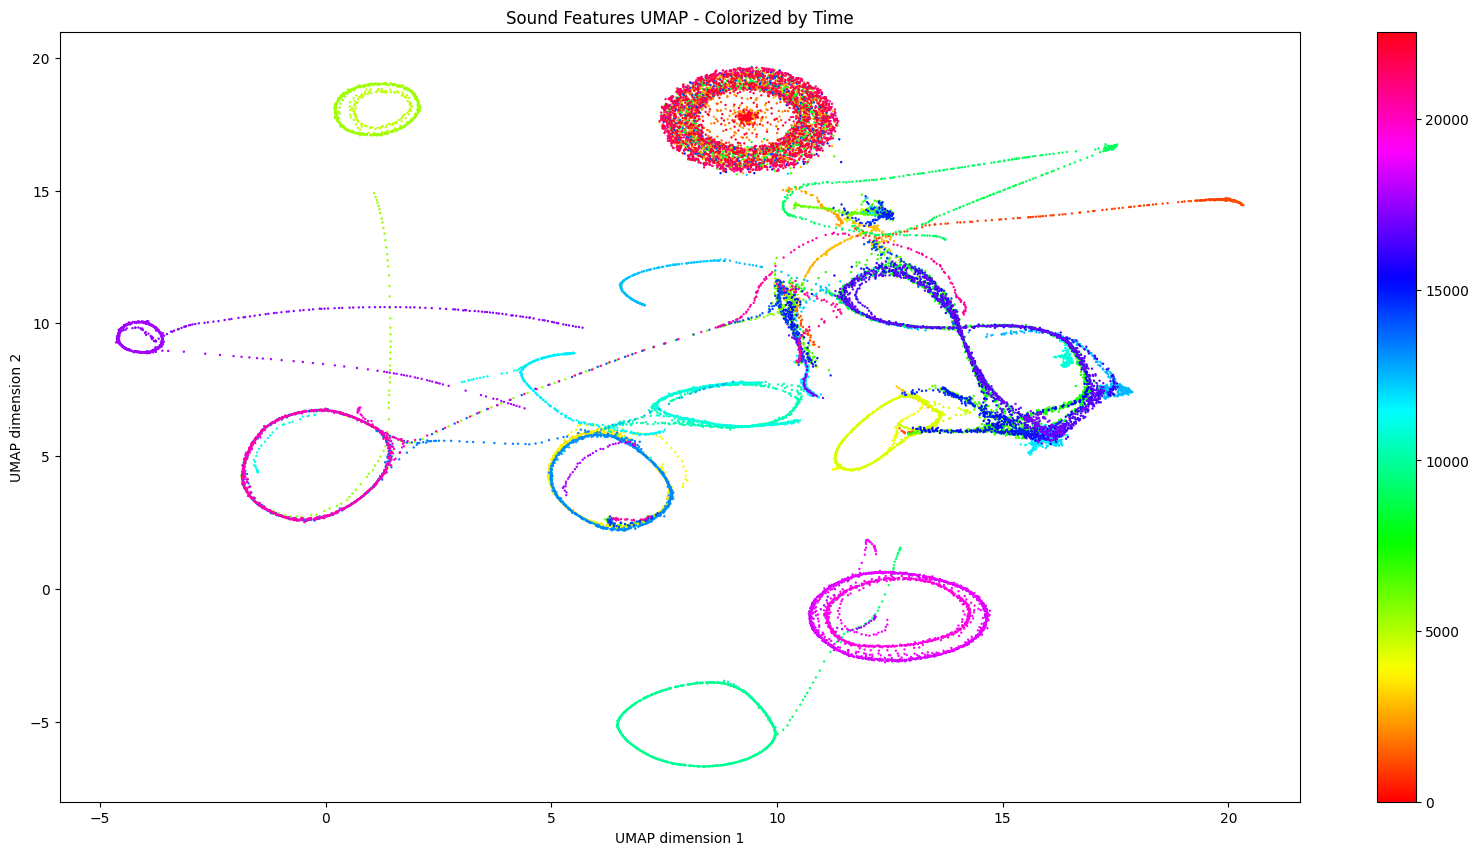

In [10]:
plt.figure(figsize=(20,10))
plt.scatter(spec_emb[:,0],spec_emb[:,1],s = .5,cmap='hsv',c = np.arange(spec_emb.shape[0]))
plt.title('Sound Features UMAP - Colorized by Time')
plt.xlabel('UMAP dimension 1')
plt.ylabel('UMAP dimension 2')
plt.colorbar()
plt.show()

## The Old Way

0.0014058956916099775


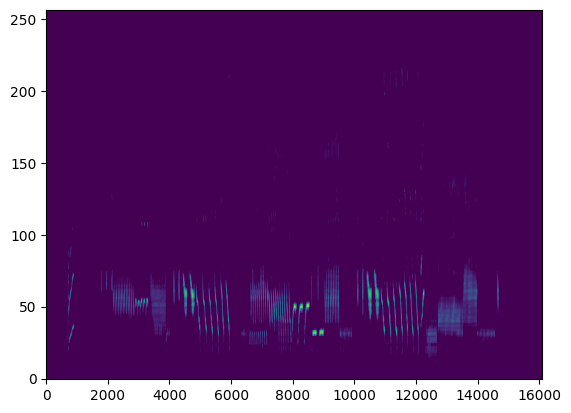

In [29]:
# UMAP slicing param in pixels/bins
window_size = 300
step_size = 5


# Obtain features and make slices
filtSpec, t, freqs = wavToSpec(demoFile)
slices, start_times = get_matrix_slices(filtSpec,window_size, step_size)

print(t[1] - t[0])
colorTime = t[start_times.astype(int)]
# Turn each slice into a 1D vector
original_shape = slices.shape
flattened_matrix = slices.reshape(original_shape[0] * original_shape[1], original_shape[2]).T

plt.imshow(filtSpec,aspect = 'auto', origin = 'lower')

In [30]:
# Load the umap library, and transform the data
import umap
fit = umap.UMAP()
spec_emb = fit.fit_transform(flattened_matrix)

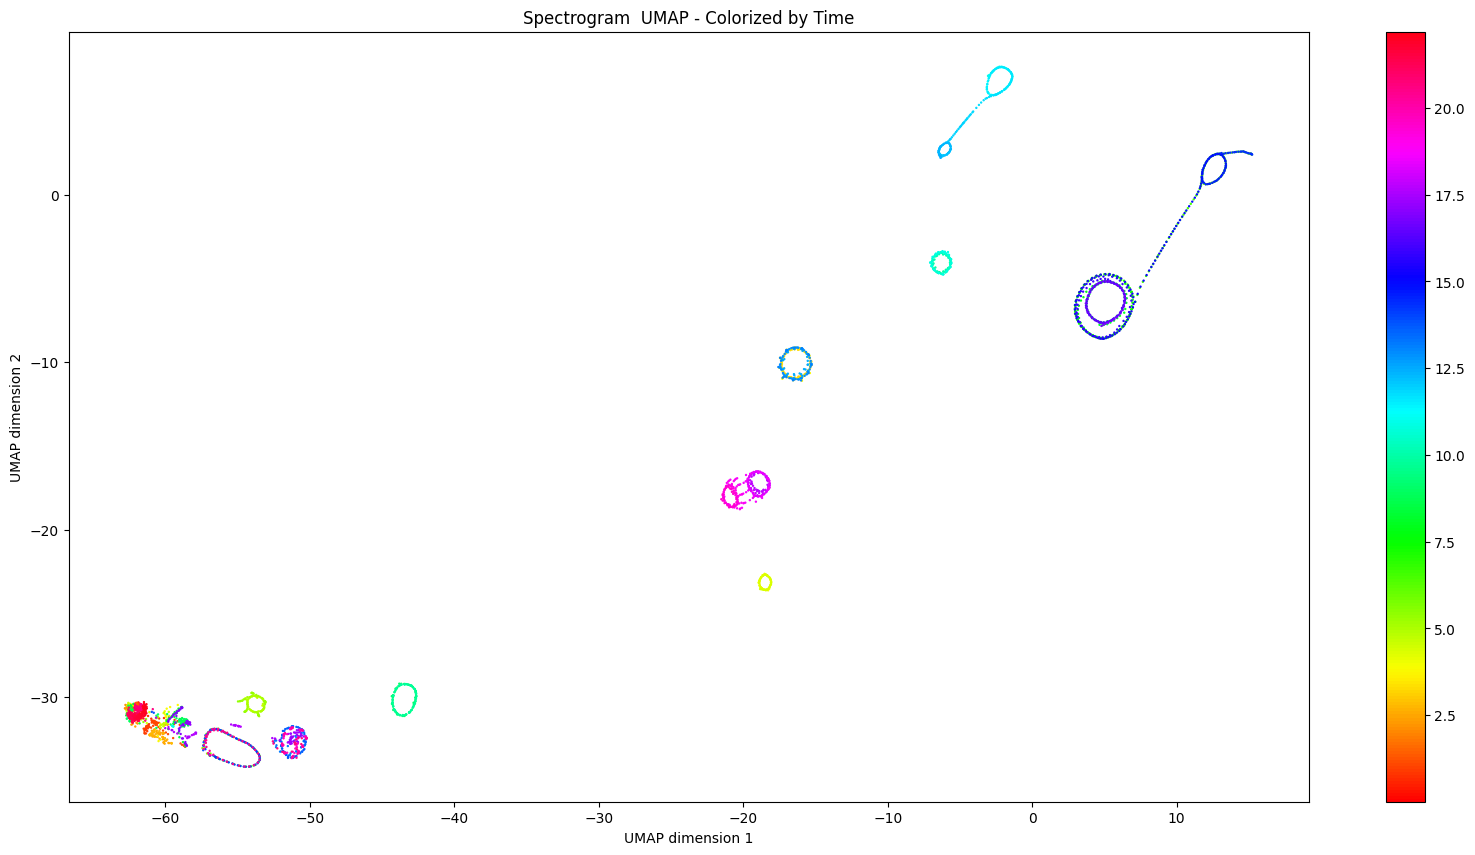

In [31]:
plt.figure(figsize=(20,10))
plt.scatter(spec_emb[:,0],spec_emb[:,1],s = .5,cmap='hsv',c = colorTime)
plt.title('Spectrogram  UMAP - Colorized by Time')
plt.xlabel('UMAP dimension 1')
plt.ylabel('UMAP dimension 2')
plt.colorbar()
plt.show()

#variable window approach?


## Pitch Stuff


In [14]:
pip install numpy scipy pyAudioAnalysis eyed3 pydub hdbscan noisereduce praat-parselmouth

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 44.9 MB/s eta 0:00:00


In [15]:
# Import Libraries
import numpy as np
import scipy
from scipy.io import wavfile
import numpy as np
from pyAudioAnalysis import ShortTermFeatures
import matplotlib.pyplot as plt
import parselmouth

In [16]:

demoSound = parselmouth.Sound(demoFile)


pitchA = demoSound.to_pitch(time_step = .0005,pitch_ceiling = 20000)# can also set pitch_floor

pitch_values = pitchA.selected_array['frequency']


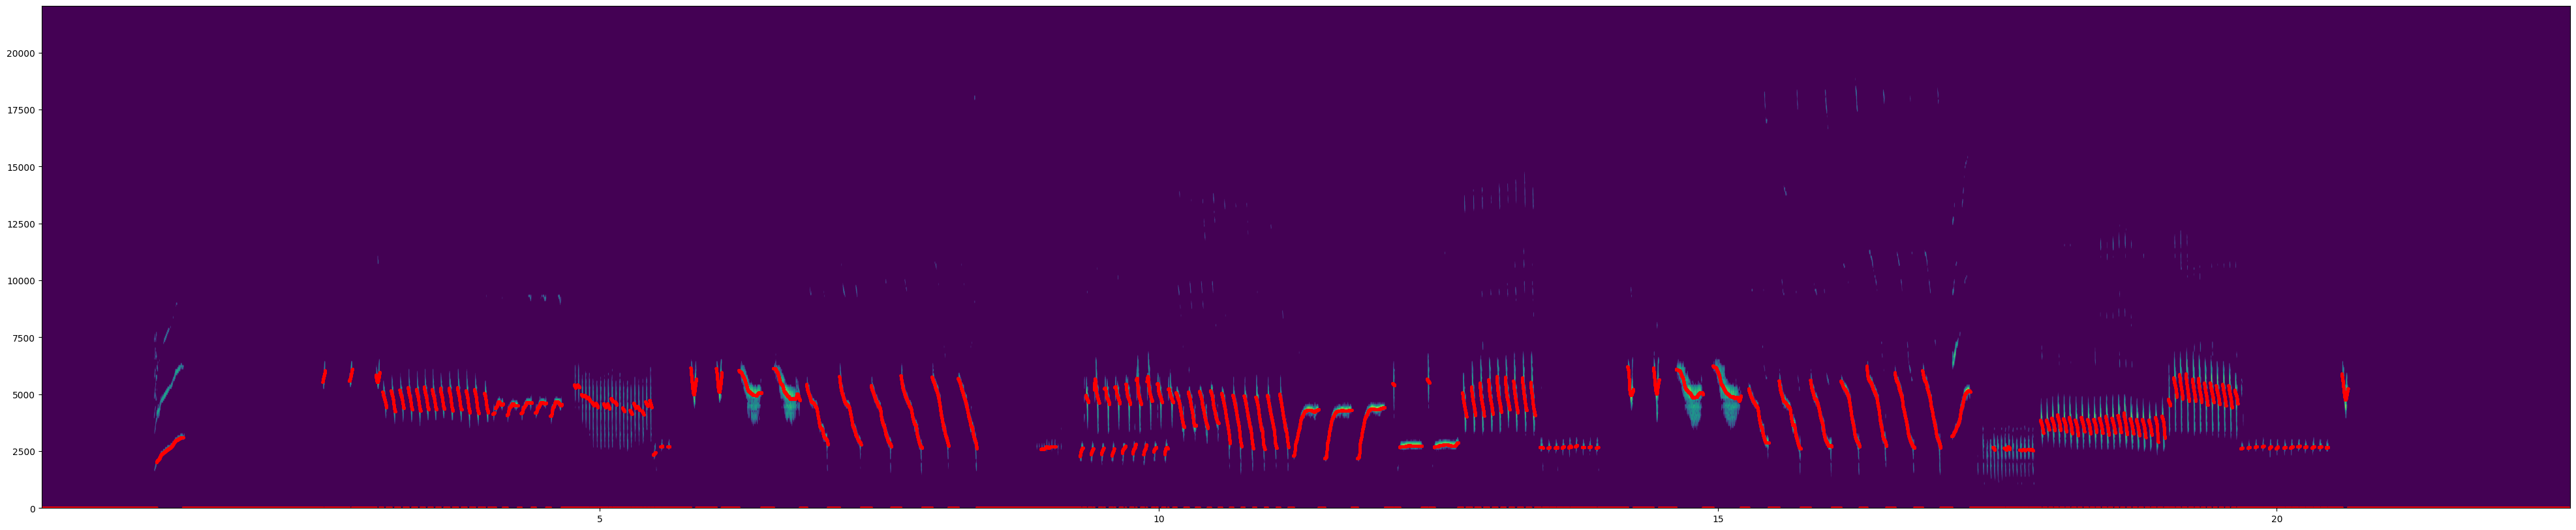

In [17]:

plt.figure(figsize = (50,10))
plt.imshow(filtSpec,aspect = 'auto',origin = 'lower',extent = [t[0],t[-1],freqs[0],freqs[-1]])
plt.plot(pitchA.xs(), pitch_values, 'o', markersize=2.5, color='red')
plt.show()

In [19]:
slices, start_times = get_matrix_slices(pitchY[np.newaxis, :], 200, 2)

original_shape = slices.shape
flattened_matrix = slices.reshape(original_shape[0] * original_shape[1], original_shape[2]).T

NameError: ignored

In [ ]:
# Load the umap library, and transform the data
import umap
fit = umap.UMAP()
spec_emb = fit.fit_transform(flattened_matrix)

In [ ]:
plt.figure(figsize=(20,10))
plt.scatter(spec_emb[:,0],spec_emb[:,1],s = .5,cmap='hsv',c = np.arange(spec_emb.shape[0]))
plt.title('Pitch  UMAP - Colorized by Time')
plt.xlabel('UMAP dimension 1')
plt.ylabel('UMAP dimension 2')
plt.colorbar()
plt.show()